In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense, Dropout
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import *

Using TensorFlow backend.


In [2]:
data =pd.read_csv("/content/drive/My Drive/Reddit_brexit_period14.csv")
data.head()

,Unnamed: 0,periods,Author,text,CommentID,ParentID,SubmissionID,leave_prob,polarization_prob,polarization_class,Date
0,206697,14,BorgDrone,The UK has to decide wether to take part in th...,ej2tada,ej2rf5q,b3witb,0.725056,0.450112,Brexit,22-03-19
1,206698,14,ShyBertHerb,Nigel Farage is my mates cousin and I met him ...,ej2tae1,ej2e7w5,b3u6s1,0.981937,0.963873,Brexit,22-03-19
2,206699,14,thefirstdetective,Hmmm... economic crash... in what economic sys...,ej2tavj,ej2t46z,b3qepz,0.334120,-0.331760,Neutral,22-03-19
3,206700,14,juan-love,But she's not stirring up hate is she? It's no...,ej2tbgr,b3u981,b3u981,0.470517,-0.058966,Neutral,22-03-19
4,206701,14,r6boarder,Why?,ej2tc9d,ej20wqj,b3rgu1,0.500000,0.000000,Neutral,22-03-19


In [3]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
data["Stance"] = lb_make.fit_transform(data["polarization_class"])
data[["polarization_class", "Stance"]].head(10)

,polarization_class,Stance
0,Brexit,1
1,Brexit,1
2,Neutral,2
3,Neutral,2
4,Neutral,2
5,Neutral,2
6,Neutral,2
7,Brexit,1
8,Brexit,1
9,Brexit,1


In [4]:
data_to_use = data['Stance'].values
data['polarization_class'].value_counts()

Neutral    6272
Brexit     3793
Against    3349
Name: polarization_class, dtype: int64

In [5]:
# create X/y pairs
df = data['Stance']
df = concat([df, df.shift(1)], axis=1)
df.dropna(inplace=True)

In [6]:
values = df.values
y1 = values[:, 1]

In [7]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(values[:,0].reshape(-1, 1))
print(scaled_data)
scaled_data.shape

[[-0.26627519]
 [ 0.95560273]
 [ 0.95560273]
 ...
 [ 0.95560273]
 [ 0.95560273]
 [-1.48815311]]


(13413, 1)

In [8]:
#y1 = to_categorical(y1)
#y1.shape
#labels = to_categorical(data['LABEL'], num_classes=3)
#do this instead of above
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(values[:, 1]), num_classes=3)

In [9]:
labels.shape

(13413, 3)

In [10]:
X_Train, X_Test, y_Train, y_Test = train_test_split(scaled_data,labels, test_size=0.20, random_state=42)

In [11]:
print(" X Training Set size is",X_Train.shape )
print(" y Training Set size is",y_Train.shape  )
print(" X Test Set size is",X_Test.shape)
print(" y Test Set size is",y_Test.shape )

 X Training Set size is (10730, 1)
 y Training Set size is (10730, 3)
 X Test Set size is (2683, 1)
 y Test Set size is (2683, 3)


In [12]:
# convert to LSTM friendly format
X_Train = X_Train.reshape(len(X_Train),1, 1)
X_Test = X_Test.reshape(len(X_Test),1,1)
print(X_Train.shape,X_Test.shape)

(10730, 1, 1) (2683, 1, 1)


In [13]:
scaled_data = scaled_data.reshape(len(scaled_data),1,1)

In [14]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Y_reg = values[:, 1]
X= scaled_data

In [15]:
from keras.optimizers import SGD, adam, rmsprop
opt = SGD(lr=0.1)
opt_alpha2 = rmsprop(lr =0.0001)
opt_alpha1 = adam(lr=0.01)

In [16]:
#cross validation -- beware lasts long
cvscores = []
loss_vals = []
val_accs = []
for train, test in kfold.split(X, Y_reg):
  #Turn labels into categorical after the split
  encoder = LabelEncoder()
  Y = to_categorical(encoder.fit_transform(Y_reg), num_classes=3)
  #define the model
  model = Sequential()
  model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_hinge', optimizer= 'adam', metrics=['accuracy'])
  
  #fit the model
  history = model.fit(X[train], Y[train], validation_data=(X[test], Y[test]), epochs=5, batch_size=256)
  #predict
  score = model.evaluate(X[test], Y[test], verbose=0)
  #store values
  loss_vals.append(history.history['val_loss'])
  val_accs.append(history.history['val_accuracy'])
  cvscores.append(score[1])
model.summary()

Train on 10730 samples, validate on 2683 samples
Epoch 1/5
10730/10730 [==============================] - 1s 114us/step - loss: 1.0010 - accuracy: 0.4367 - val_loss: 1.0002 - val_accuracy: 0.3660
Epoch 2/5
10730/10730 [==============================] - 0s 36us/step - loss: 1.0002 - accuracy: 0.4329 - val_loss: 1.0001 - val_accuracy: 0.4674
Epoch 3/5
10730/10730 [==============================] - 0s 35us/step - loss: 1.0002 - accuracy: 0.4307 - val_loss: 1.0002 - val_accuracy: 0.4167
Epoch 4/5
10730/10730 [==============================] - 0s 35us/step - loss: 1.0001 - accuracy: 0.4354 - val_loss: 1.0001 - val_accuracy: 0.4674
Epoch 5/5
10730/10730 [==============================] - 0s 33us/step - loss: 1.0001 - accuracy: 0.4347 - val_loss: 1.0002 - val_accuracy: 0.3593
Train on 10730 samples, validate on 2683 samples
Epoch 1/5
10730/10730 [==============================] - 1s 74us/step - loss: 1.0008 - accuracy: 0.4400 - val_loss: 1.0003 - val_accuracy: 0.4674
Epoch 2/5
10730/10730 [==

In [17]:
#define the model
model = Sequential()
model.build(input_shape= (1, X_Train.shape[1], X_Train.shape[2]) )
model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics = ['accuracy'])
model.summary()
#fit
history = model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=5, batch_size=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (1, 100)                  40800     
_________________________________________________________________
dense_6 (Dense)              (1, 3)                    303       
Total params: 41,103
Trainable params: 41,103
Non-trainable params: 0
_________________________________________________________________
Train on 10730 samples, validate on 2683 samples
Epoch 1/5
10730/10730 [==============================] - 20s 2ms/step - loss: 1.0736 - accuracy: 0.4591 - val_loss: 1.1097 - val_accuracy: 0.4443
Epoch 2/5
10730/10730 [==============================] - 19s 2ms/step - loss: 1.0707 - accuracy: 0.4599 - val_loss: 1.0864 - val_accuracy: 0.4443
Epoch 3/5
10730/10730 [==============================] - 19s 2ms/step - loss: 1.0724 - accuracy: 0.4615 - val_loss: 1.1096 - val_accuracy: 0.4443
Epoch 4/5
10730/10730 [==

In [18]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(12, 3.8))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'b-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b.-', label='Val accuracy')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

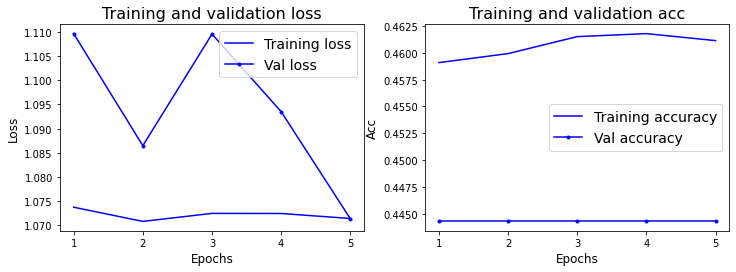

In [19]:
plot_history(history)

In [20]:
# evaluate the model
_, train_acc = model.evaluate(X_Train, y_Train, verbose=0)
_, test_acc = model.evaluate(X_Test, y_Test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.473, Test: 0.444


In [21]:

# predict probabilities for test set
yhat_probs = model.predict(X_Test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_Test, verbose=0)

In [22]:
yhat_probs[0:5]

array([[0.25552815, 0.29941106, 0.4450608 ],
       [0.25552815, 0.29941106, 0.4450608 ],
       [0.25552815, 0.29941106, 0.4450608 ],
       [0.25552815, 0.29941106, 0.4450608 ],
       [0.25552815, 0.29941106, 0.4450608 ]], dtype=float32)

In [23]:
yhat_classes[0:5]

array([2, 2, 2, 2, 2])

In [24]:
testy_inverse = np.argmax(y_Test, axis=1).reshape(-1,1)

In [25]:
print(testy_inverse.shape)
y_Test = testy_inverse[:, 0]
y_Test.shape

(2683, 1)


(2683,)

In [26]:
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

In [27]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_Test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_Test, yhat_classes,pos_label='positive',average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_Test, yhat_classes,pos_label='positive',average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_Test, yhat_classes,pos_label='positive',average='micro')
print('F1 score: %f' % f1)

Accuracy: 0.444279
Precision: 0.444279
Recall: 0.444279
F1 score: 0.444279


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [28]:
# confusion matrix
matrix = confusion_matrix(y_Test, yhat_classes)
print(matrix)

[[   0    0  701]
 [   0    0  790]
 [   0    0 1192]]


In [29]:
y_Test.shape,yhat_classes.shape

((2683,), (2683,))

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(y_Test,yhat_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       701
           1       0.00      0.00      0.00       790
           2       0.44      1.00      0.62      1192

    accuracy                           0.44      2683
   macro avg       0.15      0.33      0.21      2683
weighted avg       0.20      0.44      0.27      2683



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
